# BA875 - ISS Board of Directors History Analysis Project
Team 2: Asra Ahmed, Dhruv Shah, Jessica Tong, Parita Patel, Priyanka Chaudhari

---
## Importing Data

In [52]:
pip install pyfixest

Note: you may need to restart the kernel to use updated packages.


In [53]:
# Importing necessary libraries
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from pyfixest import feols, fepois
from pyfixest import etable
from sklearn.impute import SimpleImputer

In [54]:
# Importing data from google cloud storage
compustats= pd.read_csv('gs://ba875-team2/Compustat_Company_Financials_Subset.csv')
directors = pd.read_csv('gs://ba875-team2/ISS_Board_of_Directors_History_subset.csv')
operation = pd.read_csv('gs://ba875-team2/WRDS_IBES_Company_Financials_Yearly_subset.csv')

In [55]:
directors.columns

Index(['cusip', 'ticker', 'name', 'company_id', 'year', 'director_detail_id',
       'first_name', 'last_name', 'fullname', 'age', 'ethnicity', 'female',
       'primary_employer', 'prititle', 'year_term_ends',
       'pcnt_ctrl_votingpower', 'outside_public_boards', 'employment_ceo',
       'employment_chairman', 'employment_president',
       'employment_vicechairman', 'employment_cfo', 'employment_coo',
       'former_employee_yn', 'relative_yn'],
      dtype='object')

In [56]:
compustats.columns

Index(['gvkey', 'fyear', 'tic', 'cusip', 'conm', 'curncd', 'at', 'capx',
       'cogs', 'emp', 'invfg', 'invrm', 'invt', 'invwip', 'ni', 'ppegt',
       'ppent', 'revt', 'xrd', 'xsga', 'busdesc', 'city', 'gind', 'gsector',
       'naics', 'sic'],
      dtype='object')

In [57]:
operation.columns

Index(['gvkey', 'ticker', 'cusip', 'year', 'roa', 'invt_act',
       'cash_conversion', 'inv_turn', 'at_turn', 'rd_sale', 'staff_sale'],
      dtype='object')

---
## Data cleaning

---
### Operations/Finance Table (IBES)

In [58]:
# Finding the percent of null values in the operations table
(operation.isna().sum()/len(operation)).sort_values(ascending= False)

inv_turn           0.287975
cash_conversion    0.285217
invt_act           0.188442
staff_sale         0.048425
at_turn            0.042390
ticker             0.035152
cusip              0.032690
roa                0.002592
gvkey              0.000000
year               0.000000
rd_sale            0.000000
dtype: float64

In [59]:
# Select columns of type 'float64' from the DataFrame 'operation'
int_cols = operation.select_dtypes(include='float64').columns

# Iterate over each column selected
for col in operation[int_cols]:
    # Fill missing values in each column with the median of that column
    operation[col] = operation[col].fillna(operation[col].median())

---
### Compustats Table

In [60]:
# Computing the proportion of missing values in each column by dividing the sum of missing values by the total number of rows
(compustats.isna().sum()/len(compustats)).sort_values(ascending= False)

xrd        0.699536
invwip     0.526922
invrm      0.525189
invfg      0.522993
xsga       0.445824
ppegt      0.389645
emp        0.370705
capx       0.342850
ni         0.337485
cogs       0.337479
invt       0.316387
ppent      0.267731
revt       0.249260
at         0.245641
gsector    0.233045
gind       0.233045
naics      0.043188
fyear      0.001362
curncd     0.001362
busdesc    0.001247
tic        0.000730
cusip      0.000712
gvkey      0.000000
city       0.000000
conm       0.000000
sic        0.000000
dtype: float64

In [61]:
# Select columns of type 'float64' from the DataFrame 'compustats'
int_cols = compustats.select_dtypes(include='float64').columns

# Iterate over each column selected
for col in compustats[int_cols]:
    # Fill missing values in each column with the median of that column
    compustats[col] = compustats[col].fillna(compustats[col].median())

In [62]:
# Rename columns 'fyear' to 'year' and 'tic' to 'ticker' in the DataFrame 'compustats'
compustats.rename(columns={'fyear': 'year', 'tic': 'ticker'}, inplace=True)

In [63]:
# Compute the count of unique values in the 'gsector' column
compustats['gsector'].value_counts()

gsector
35.0    55992
40.0    29460
15.0    13245
45.0    13135
20.0    12470
25.0    10794
10.0     9817
60.0     6431
50.0     4809
30.0     4533
55.0     3733
Name: count, dtype: int64

In [64]:
# Define a dictionary that maps sector codes to sector names
sector_mapping = {
    35: 'Healthcare',
    40: 'Financials',
    15: 'Materials',
    45: 'IT',
    20: 'Industrials',
    25: 'Consumer_Discretionary',
    10: 'Energy',
    60: 'Real_Estate',
    50: 'Communication_Services',
    30: 'Consumer_Staples',
    55: 'Utilities'
}

# Apply the mapping to the 'gsector' column using a lambda function
compustats['gsector'] = compustats['gsector'].apply(lambda x: sector_mapping.get(x, x))


---
### Directors Table

In [65]:
# Create one-hot encoded dummy variables for the 'ethnicity' and 'prititle' columns
directors_onehot = pd.get_dummies(directors, columns=['ethnicity', 'prititle'])

In [66]:
directors_onehot.columns

Index(['cusip', 'ticker', 'name', 'company_id', 'year', 'director_detail_id',
       'first_name', 'last_name', 'fullname', 'age', 'female',
       'primary_employer', 'year_term_ends', 'pcnt_ctrl_votingpower',
       'outside_public_boards', 'employment_ceo', 'employment_chairman',
       'employment_president', 'employment_vicechairman', 'employment_cfo',
       'employment_coo', 'former_employee_yn', 'relative_yn',
       'ethnicity_ASIAN (EXCLUDE INDIAN/SOUTH ASIAN)',
       'ethnicity_BLACK/AFRICAN AMERICAN', 'ethnicity_CAUCASIAN/WHITE',
       'ethnicity_HISPANIC/LATIN AMERICAN', 'ethnicity_INDIAN/SOUTH ASIAN',
       'ethnicity_MIDDLE-EASTERN/NORTH AFRICAN', 'ethnicity_N/C',
       'ethnicity_NATIVE AMERICAN/ALASKAN NATIVE',
       'ethnicity_NATIVE HAWAIIAN/OTHER PACIFIC ISLANDER', 'ethnicity_OTHER',
       'ethnicity_PREFER NOT TO DISCLOSE', 'ethnicity_UNKNOWN',
       'prititle_Academic', 'prititle_Accountant', 'prititle_Attorney/Counsel',
       'prititle_Consultant', 'priti

In [67]:
# Converting column names to lowercase
directors_onehot.columns = directors_onehot.columns.str.lower()

# Replacing spaces with underscores in column names
directors_onehot.columns = directors_onehot.columns.str.replace(' ', '_')

# Defining a dictionary mapping original column names to new column names
column_name_mapping = {
    'ethnicity_asian_(exclude_indian/south_asian)': 'ethnicity_asian',
    'ethnicity_native_hawaiian/other_pacific_islander': 'ethnicity_pacific_islander',
    'ethnicity_black/african_american': 'ethnicity_black_or_african_american',
    'ethnicity_caucasian/white': 'ethnicity_caucasian_or_white',
    'ethnicity_hispanic/latin_american': 'ethnicity_hispanic_or_latin_american',
    'ethnicity_indian/south_asian': 'ethnicity_indian_or_south_asian',
    'ethnicity_middle-eastern/north_african': 'ethnicity_middleeastern_or_north_african',
    'ethnicity_native_american/alaskan_native': 'ethnicity_native_american_or_alaskan_native',
    'ethnicity_n/c': 'ethnicity_n_c',
    'prititle_attorney/counsel': 'prititle_attorney_counsel'
}

# Renaming columns according to the mapping
directors_onehot = directors_onehot.rename(columns=column_name_mapping)


In [68]:
# List of columns to convert to binary (integer) type
binary_cols = [
    'ethnicity_asian', 'ethnicity_black_or_african_american',
    'ethnicity_caucasian_or_white', 'ethnicity_hispanic_or_latin_american',
    'ethnicity_indian_or_south_asian', 'ethnicity_middleeastern_or_north_african',
    'ethnicity_n_c', 'ethnicity_native_american_or_alaskan_native',
    'ethnicity_pacific_islander', 'ethnicity_other', 'ethnicity_prefer_not_to_disclose',
    'ethnicity_unknown', 'prititle_attorney_counsel', 'prititle_academic',
    'prititle_accountant', 'prititle_consultant', 'prititle_executive',
    'prititle_financial_services', 'prititle_medical', 'prititle_other',
    'prititle_prof_director', 'prititle_real_estate_services', 'prititle_retired'
]

# Convert columns to integer type (binary)
directors_onehot[binary_cols] = directors_onehot[binary_cols].astype(int)

In [69]:
# Add a new column named 'board_mems' with a value of 1 for each row
directors_onehot['board_mems'] = 1

In [70]:
# Group by 'ticker' and 'year', then aggregate statistics for each company for a particular year
yr_directors = directors_onehot.groupby(['ticker', 'year']).agg({
    'board_mems': 'sum',  # Sum of 'board_mems' for each group
    'age': 'mean',  # Mean of 'age' for each group
    'pcnt_ctrl_votingpower': 'median',  # Median of 'pcnt_ctrl_votingpower' for each group
    'female': 'count',  # Count of 'female' for each group (total number of females)
    'year_term_ends': 'median',  # Median of 'year_term_ends' for each group
    'outside_public_boards': 'sum',  # Sum of 'outside_public_boards' for each group
    'employment_ceo': 'count',  # Count of 'employment_ceo' for each group (total number of CEOs)
    'employment_chairman': 'count',  # Count of 'employment_chairman' for each group (total number of Chairmen)
    'employment_president': 'count',  # Count of 'employment_president' for each group (total number of Presidents)
    'employment_vicechairman': 'count',  # Count of 'employment_vicechairman' for each group (total number of Vice Chairmen)
    'employment_cfo': 'count',  # Count of 'employment_cfo' for each group (total number of CFOs)
    'employment_coo': 'count',  # Count of 'employment_coo' for each group (total number of COOs)
    'former_employee_yn': 'count',  # Count of 'former_employee_yn' for each group (total number of former employees)
    'relative_yn': 'count',  # Count of 'relative_yn' for each group (total number of relatives)
    # Sum of binary columns indicating ethnicity categories for each company for a particular year
    'ethnicity_black_or_african_american': 'sum',
    'ethnicity_caucasian_or_white': 'sum',
    'ethnicity_hispanic_or_latin_american': 'sum',
    'ethnicity_indian_or_south_asian': 'sum',
    'ethnicity_pacific_islander': 'sum',
    'ethnicity_other': 'sum',
    'ethnicity_prefer_not_to_disclose': 'sum',
    'ethnicity_unknown': 'sum',
    'ethnicity_middleeastern_or_north_african': 'sum',
    'ethnicity_native_american_or_alaskan_native': 'sum',
    # Sum of binary columns indicating professional titles for each company for a particular year
    'prititle_academic': 'sum',
    'prititle_accountant': 'sum',
    'prititle_attorney_counsel': 'sum',
    'prititle_consultant': 'sum',
    'prititle_executive': 'sum',
    'prititle_financial_services': 'sum',
    'prititle_medical': 'sum',
    'prititle_other': 'sum',
    'prititle_prof_director': 'sum',
    'prititle_real_estate_services': 'sum',
    'prititle_retired': 'sum'
}).reset_index()  # Reset index to make 'ticker' and 'year' regular columns

In [71]:
from sklearn.impute import SimpleImputer

# Instantiating a SimpleImputer object with the strategy set to 'median'
imputer = SimpleImputer(strategy='median')

# List of numeric columns to impute missing values
numeric_cols = ['pcnt_ctrl_votingpower', 'year_term_ends', 'age', 'outside_public_boards']

# Using the imputer to fit and transform the specified numeric columns, replacing missing values with the median
yr_directors[numeric_cols] = imputer.fit_transform(yr_directors[numeric_cols])

In [72]:
# Checking null values 
(yr_directors.isna().sum()/len(yr_directors)).sort_values(ascending= False)

ticker                                         0.0
ethnicity_indian_or_south_asian                0.0
ethnicity_other                                0.0
ethnicity_prefer_not_to_disclose               0.0
ethnicity_unknown                              0.0
ethnicity_middleeastern_or_north_african       0.0
ethnicity_native_american_or_alaskan_native    0.0
prititle_academic                              0.0
prititle_accountant                            0.0
prititle_attorney_counsel                      0.0
prititle_consultant                            0.0
prititle_executive                             0.0
prititle_financial_services                    0.0
prititle_medical                               0.0
prititle_other                                 0.0
prititle_prof_director                         0.0
prititle_real_estate_services                  0.0
ethnicity_pacific_islander                     0.0
ethnicity_hispanic_or_latin_american           0.0
year                           

---
## Merging tables

In [73]:
# Merging compustats and yr_directors DataFrames on columns 'ticker' and 'year' using inner join
merged_data = compustats.merge(yr_directors, on=['ticker', 'year'], how='inner')

# Merging the resulting DataFrame with the operation DataFrame on columns 'ticker' and 'year' using inner join
merged_data = merged_data.merge(operation, on=['ticker', 'year'], how='inner')


In [74]:
merged_data.to_csv('gs://ba875-team2/merged_df_new.csv')

| Column                                       | Description                                                                                           |
|----------------------------------------------|-------------------------------------------------------------------------------------------------------|
| gvkey_x                                      | Unique identifier for each company.                                                                    |
| year                                         | Year of the data record.                                                                               |
| ticker                                       | Ticker symbol of the company.                                                                          |
| cusip_x                                      | CUSIP number of the company.                                                                           |
| conm                                         | Name of the company.                                                                                   |
| curncd                                       | Currency code used for financial data.                                                                 |
| at                                           | Total assets of the company.                                                                           |
| capx                                         | Capital expenditures of the company.                                                                   |
| cogs                                         | Cost of goods sold for the company.                                                                    |
| emp                                          | Number of employees in the company.                                                                    |
| invfg                                        | Inventory finished goods for the company.                                                              |
| invrm                                        | Inventory raw materials for the company.                                                               |
| invt                                         | Total inventory for the company.                                                                       |
| invwip                                       | Inventory work in progress for the company.                                                            |
| ni                                           | Net income of the company.                                                                             |
| ppegt                                        | Gross property, plant, and equipment for the company.                                                  |
| ppent                                        | Net property, plant, and equipment for the company.                                                     |
| revt                                         | Total revenue for the company.                                                                         |
| xrd                                          | Research and development expenses for the company.                                                     |
| xsga                                         | Selling, general, and administrative expenses for the company.                                          |
| busdesc                                      | Description of the company's business.                                                                 |
| city                                         | City where the company is located.                                                                     |
| gind                                         | Global Industry Classification Standard (GICS) industry code for the company.                          |
| gsector                                      | GICS sector for the company.                                                                           |
| naics                                        | North American Industry Classification System (NAICS) code for the company.                            |
| sic                                          | Standard Industrial Classification (SIC) code for the company.                                          |
| board_mems                                   | Number of board members for the company.                                                                |
| age                                          | Age of the company.                                                                                    |
| pcnt_ctrl_votingpower                        | Percentage of control voting power for the company.                                                     |
| female                                       | Count of female directors in the company.                                                               |
| year_term_ends                               | Year when the term ends for the company.                                                               |
| outside_public_boards                        | Number of directors serving on outside public boards for the company.                                   |
| employment_ceo                               | Count of directors with CEO employment title for the company.                                            |
| employment_chairman                          | Count of directors with Chairman employment title for the company.                                       |
| employment_president                         | Count of directors with President employment title for the company.                                      |
| employment_vicechairman                      | Count of directors with Vice Chairman employment title for the company.                                  |
| employment_cfo                               | Count of directors with CFO employment title for the company.                                            |
| employment_coo                               | Count of directors with COO employment title for the company.                                            |
| former_employee_yn                           | Count of former employees serving as directors for the company.                                          |
| relative_yn                                  | Count of directors who are relatives of company executives.                                              |
| ethnicity_black_or_african_american          | Count of directors who are Black or African American.                                                   |
| ethnicity_caucasian_or_white                 | Count of directors who are Caucasian or White.                                                           |
| ethnicity_hispanic_or_latin_american         | Count of directors who are Hispanic or Latin American.                                                   |
| ethnicity_indian_or_south_asian              | Count of directors who are Indian or South Asian.                                                        |
| ethnicity_pacific_islander                   | Count of directors who are Pacific Islander.                                                            |
| ethnicity_other                              | Count of directors who belong to other ethnicities.                                                      |
| ethnicity_prefer_not_to_disclose             | Count of directors who prefer not to disclose their ethnicity.                                           |
| ethnicity_unknown                            | Count of directors whose ethnicity is unknown.                                                           |
| ethnicity_middleeastern_or_north_african     | Count of directors who are Middle Eastern or North African.                                              |
| ethnicity_native_american_or_alaskan_native  | Count of directors who are Native American or Alaskan Native.                                            |
| prititle_academic                            | Count of directors with Academic employment title for the company.                                       |
| prititle_accountant                          | Count of directors with Accountant employment title for the company.                                     |
| prititle_attorney_counsel                    | Count of directors with Attorney or Counsel employment title for the company.                             |
| prititle_consultant                          | Count of directors with Consultant employment title for the company.                                     |
| prititle_executive                           | Count of directors with Executive employment title for the company.                                      |
| prititle_financial_services                  | Count of directors with Financial Services employment title for the company.                              |
| prititle_medical                             | Count of directors with Medical employment title for the company.                                         |
| prititle_other                               | Count of directors with other employment titles for the company.                                          |
| prititle_prof_director                       | Count of directors with Professional Director employment title for the company.                           |
| prititle_real_estate_services                | Count of directors with Real Estate Services employment title for the company.                            |
| prititle_retired                             | Count of directors who are retired.                                                                     |
| gvkey_y                                      | Unique identifier for each company (duplicate of gvkey_x).                                               |
| cusip_y                                      | CUSIP number of the company (duplicate of cusip_x).                                                      |
| roa                                          | Return on Assets (ROA) for the company.                                                                 |
| invt_act                                     | Inventory turnover ratio for the company.                                                               |
| cash_conversion                              | Cash conversion cycle for the company.                                                                  |
| inv_turn                                     | Inventory turnover for the company.                                                                    |
| at_turn                                      | Asset turnover for the company.                                                                        |
| rd_sale                                      | Research and development expenses as a percentage of sales for the company.                              |
| staff_sale                                   | Selling, general, and administrative expenses as a percentage of sales for the company.                  |


---
## Descriptive Statistics

In [75]:
merged_data[['year', 'revt', 'roa', 'ni']].describe()

,year,revt,roa,ni
count,16956.000000,16956.000000,16956.000000,16956.000000
mean,2015.685008,9874.244102,0.118175,716.188172
std,3.542776,28529.886625,0.099763,3026.789502
min,2009.000000,0.000000,-0.813182,-23119.000000
25%,2013.000000,769.931500,0.047500,4.299000
50%,2016.000000,2147.768500,0.109250,97.810500
75%,2019.000000,7014.600000,0.164909,414.435750
max,2022.000000,608481.000000,1.408273,99803.000000


We can see that the data spans from 2009 to 2022, however, notably, 2022 had the fewest datapoints (only 249). 

The Total Revenue is reported in USD millions, with the highest revenue for a ticker for a year being USD 608,481 million. The average Total Revenue is USD 2,147 million per year.

The Average ROA is 0.1, and the average Net Income 97.8 USD million.

---
## Exploratory Data Analysis (EDA)

---
### Distribution of Average Board Member Ages Across Tickers

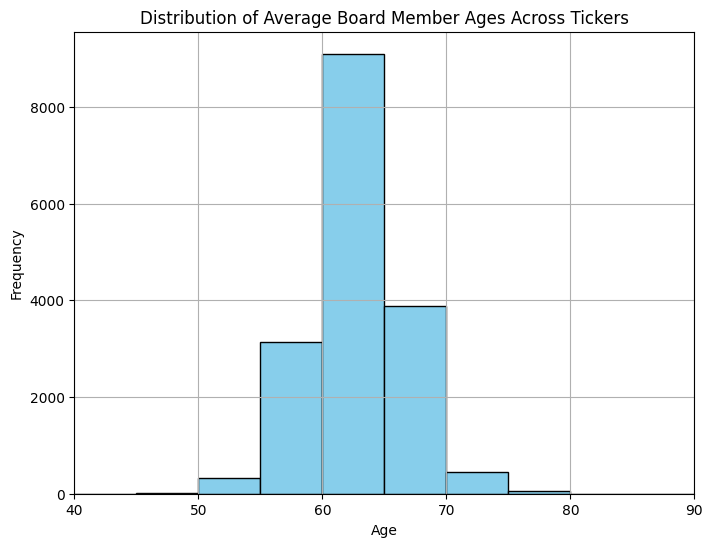

In [76]:
import matplotlib.pyplot as plt

# Define the age range of interest
age_range = (40, 90)

# Create a histogram focusing on the specified age range
plt.figure(figsize=(8, 6))
plt.hist(merged_data['age'], bins=range(age_range[0], age_range[1] + 5, 5), color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Average Board Member Ages Across Tickers')
plt.xlim(age_range)  # Limit x-axis to the specified age range
plt.grid(True)
plt.show()

The graph shows that the average age across a board of directors for majority of the companies in this dataset lies around the age of 60-70.

---
### Distribution of Ethnicity in our dataset

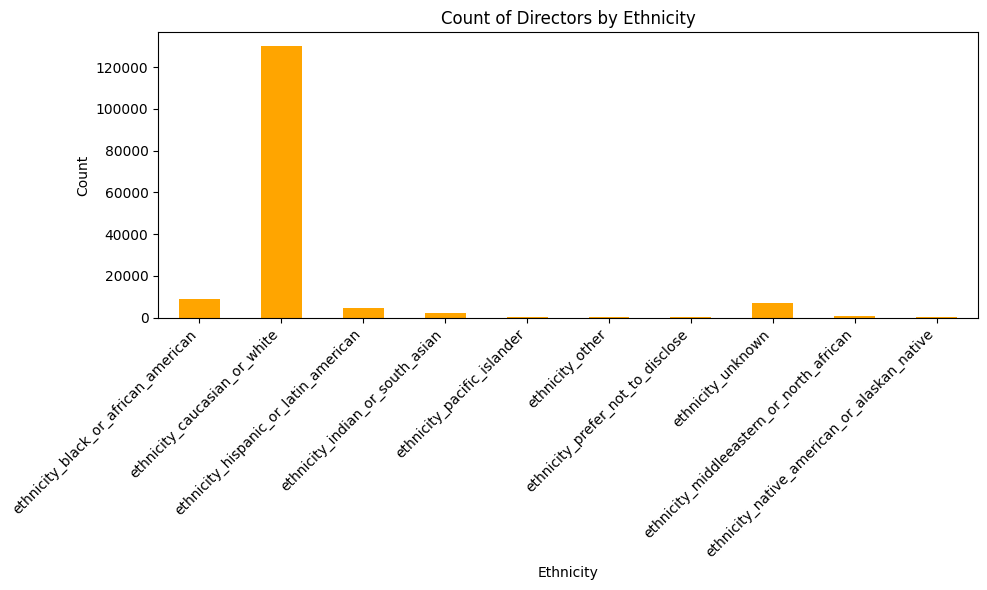

In [77]:
ethnicity_counts = merged_data.filter(like='ethnicity_').sum()

plt.figure(figsize=(10, 6))
ethnicity_counts.plot(kind='bar', color='orange')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.title('Count of Directors by Ethnicity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


The data visualization suggests a significant representation of Caucasian board members compared to other ethnicities in our dataset.

---
### Distribution of Board Members by Employment Title

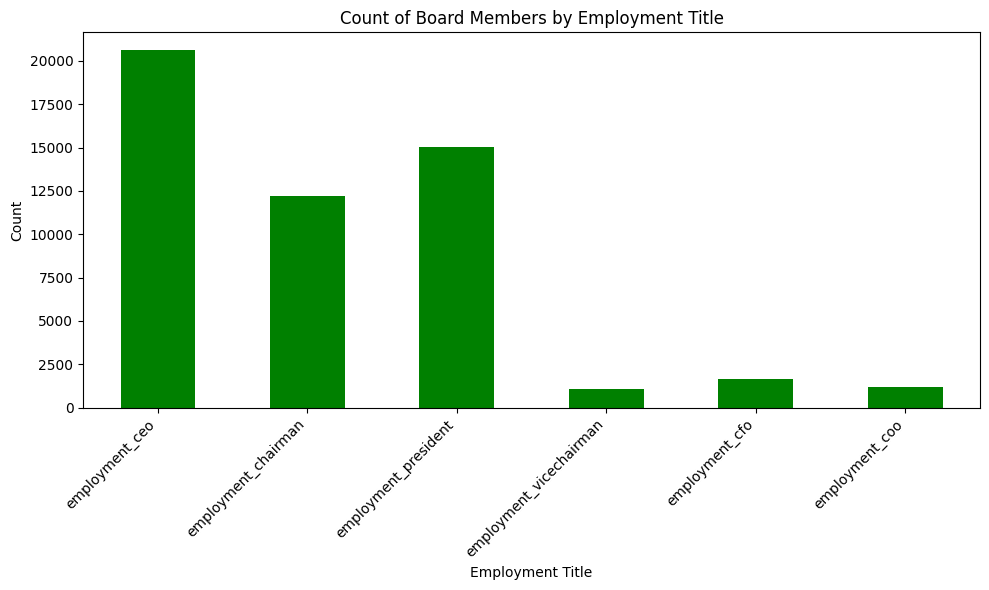

In [78]:
employment_titles = merged_data.filter(like='employment_').sum()

plt.figure(figsize=(10, 6))
employment_titles.plot(kind='bar', color='green')
plt.xlabel('Employment Title')
plt.ylabel('Count')
plt.title('Count of Board Members by Employment Title')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Our data visualization reveals that CEOs, presidents, and chairmen are the most frequent board member positions across all companies in the dataset.

---
### Average Number of Female Board Members Increases over the years in each sector

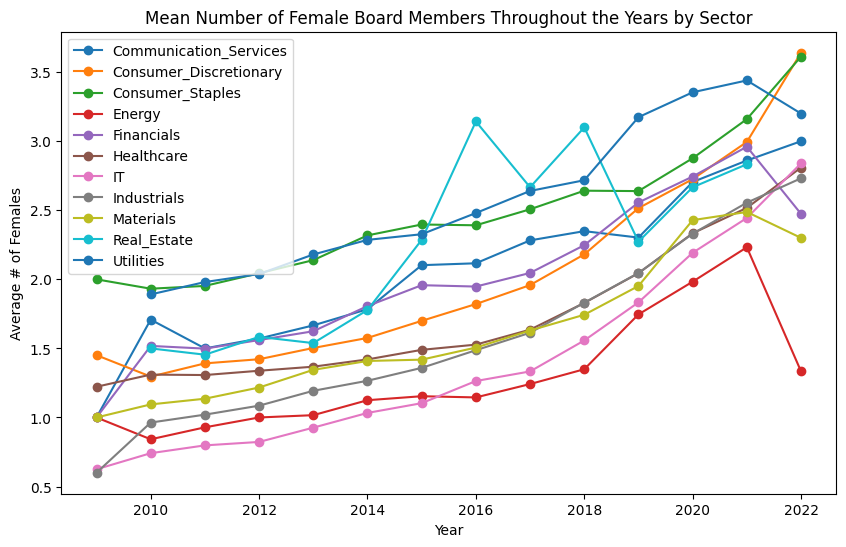

In [79]:
grouped_df = merged_data.groupby(['year', 'gsector'])['female'].mean().reset_index()

# Get the unique sectors
sectors = grouped_df['gsector'].unique()

plt.figure(figsize=(10,6))

# For each sector, plot a line with 'year' on the x-axis and the count of CEOs on the y-axis
for sector in sectors:
    subset = grouped_df[grouped_df['gsector'] == sector]
    plt.plot(subset['year'], subset['female'], marker='o', label=sector)

plt.title('Mean Number of Female Board Members Throughout the Years by Sector')
plt.xlabel('Year')
plt.ylabel('Average # of Females')
plt.legend()

plt.show()

From the vizualization we can see that the average number of female board members in a board has been on an upward trend since 2008. Since 2008, the average number of female board members has increased by 150% in the Consumer Discretionary sector, as shown in the visualization

---
### Total Revenue Across the Years Across Sectors - Significant Rise in Healthcare (could be reflective of Covid-19)

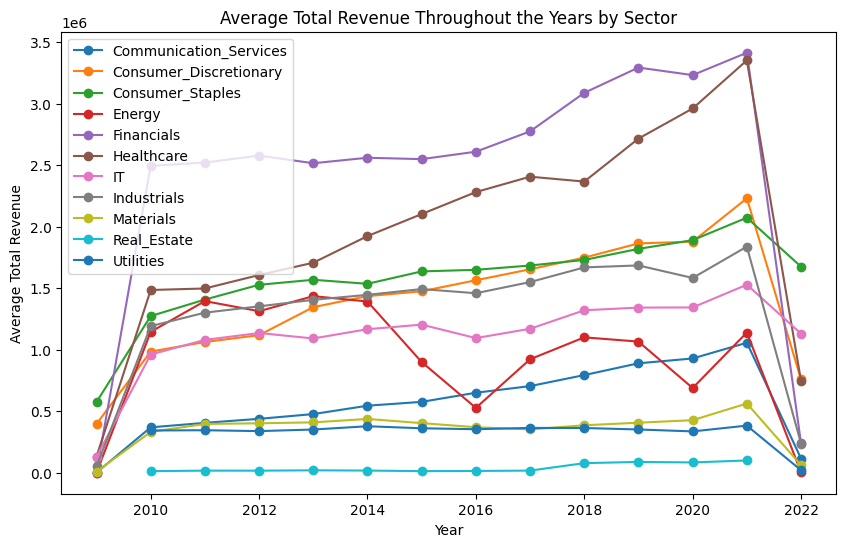

In [80]:
grouped_df = merged_data.groupby(['year', 'gsector'])['revt'].sum().reset_index()

# Get the unique sectors
sectors = grouped_df['gsector'].unique()

plt.figure(figsize=(10,6))

# For each sector, plot a line with 'year' on the x-axis and the count of CEOs on the y-axis
for sector in sectors:
    subset = grouped_df[grouped_df['gsector'] == sector]
    plt.plot(subset['year'], subset['revt'], marker='o', label=sector)

plt.title('Average Total Revenue Throughout the Years by Sector')
plt.xlabel('Year')
plt.ylabel('Average Total Revenue')
plt.legend()

plt.show()

The visualization reveals some intriguing sectoral trends. Notably, the healthcare sector exhibits a sharp uptick, particularly after 2019. This likely corresponds to the impact of the pandemic. In contrast, the energy sector experiences a decline from 2014 to 2016, followed by a slow recovery before another downturn in 2020. It's important to consider that our 2022 data has limited data points compared to other years, potentially influencing the results for that period.

---
### Mean Age of Board Members Throughout the Years by Sector

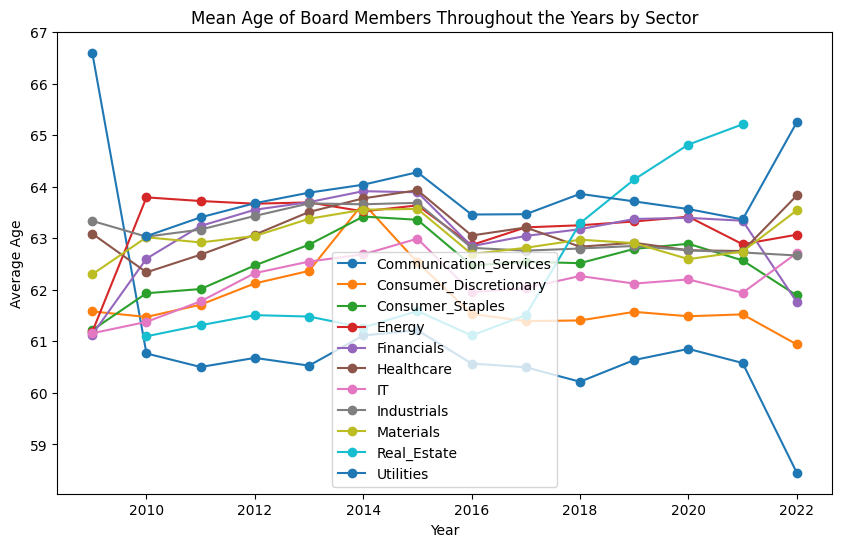

In [81]:
grouped_df = merged_data.groupby(['year', 'gsector'])['age'].mean().reset_index()

# Get the unique sectors
sectors = grouped_df['gsector'].unique()

plt.figure(figsize=(10,6))

# For each sector, plot a line with 'year' on the x-axis and the count of CEOs on the y-axis
for sector in sectors:
    subset = grouped_df[grouped_df['gsector'] == sector]
    plt.plot(subset['year'], subset['age'], marker='o', label=sector)

plt.title('Mean Age of Board Members Throughout the Years by Sector')
plt.xlabel('Year')
plt.ylabel('Average Age')
plt.legend()

plt.show()

The data visualization highlights a fascinating divergence in board age trends across sectors. The real estate sector shows a distinct upward trend in the average age of directors, while the utilities sector exhibits a contrasting downward trend. Directors' average age in other sectors appears to be relatively stable over time.

---
### Average outside public board count Throughout the Years by Sector

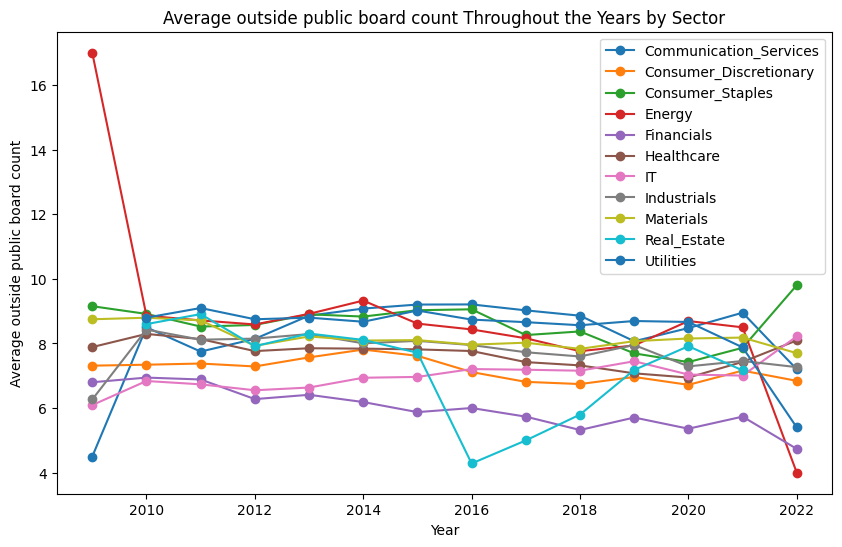

In [82]:
grouped_df = merged_data.groupby(['year', 'gsector'])['outside_public_boards'].mean().reset_index()

# Get the unique sectors
sectors = grouped_df['gsector'].unique()

plt.figure(figsize=(10,6))

# For each sector, plot a line with 'year' on the x-axis and the count of CEOs on the y-axis
for sector in sectors:
    subset = grouped_df[grouped_df['gsector'] == sector]
    plt.plot(subset['year'], subset['outside_public_boards'], marker='o', label=sector)

plt.title('Average outside public board count Throughout the Years by Sector')
plt.xlabel('Year')
plt.ylabel('Average outside public board count')
plt.legend()

plt.show()

The visualization reveals a trend of stability in the average number of outside public board members across different sectors over the years. However, the real estate sector stands out with a significant dip in 2016.  Fortunately, it appears to have recovered and returned to the average level since then.

---
## VIF

In [83]:
# Selecting numeric columns for VIF calculation
numeric_columns = ['at', 'capx',
       'cogs', 'emp', 'invfg', 'invrm', 'invt', 'invwip', 'ppegt',
       'ppent', 'xrd', 'xsga',
       'naics', 'sic', 'board_mems', 'age', 'pcnt_ctrl_votingpower', 'female',
       'year_term_ends', 'outside_public_boards', 'employment_ceo',
       'employment_chairman', 'employment_president',
       'employment_vicechairman', 'employment_cfo', 'employment_coo',
       'former_employee_yn', 'relative_yn', 'ethnicity_black_or_african_american',
       'ethnicity_caucasian_or_white', 'ethnicity_hispanic_or_latin_american',
       'ethnicity_indian_or_south_asian',
       'ethnicity_middleeastern_or_north_african',
       'ethnicity_native_american_or_alaskan_native',  'ethnicity_pacific_islander',
        'prititle_attorney_counsel',
       'prititle_academic', 'prititle_accountant','prititle_consultant', 'prititle_executive',
        'prititle_financial_services' , 'prititle_medical' ,'prititle_other', 'prititle_prof_director', 
        'prititle_real_estate_services' , 'prititle_retired',
        'ethnicity_other', 'ethnicity_prefer_not_to_disclose', 'ethnicity_unknown', 'roa',
       'invt_act', 'cash_conversion', 'inv_turn', 'at_turn', 'rd_sale',
       'staff_sale']

# Subset DataFrame with numeric columns for VIF
df_vif = merged_data[numeric_columns]

# Fill missing values if any
df_vif.fillna(0, inplace=True)  # You can choose appropriate method to fill missing values

# Standardize features
scaler = StandardScaler()
df_vif_scaled = scaler.fit_transform(df_vif)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = df_vif.columns
vif_data["VIF"] = [variance_inflation_factor(df_vif_scaled, i) for i in range(df_vif_scaled.shape[1])]

# Print VIF data
high_vif_data = vif_data[vif_data['VIF'] > 5]
high_vif_data

/var/tmp/ipykernel_6271/2320572249.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vif.fillna(0, inplace=True)  # You can choose appropriate method to fill missing values


,Feature,VIF
1,capx,6.402527
8,ppegt,22.525832
9,ppent,24.515288
11,xsga,5.054572
14,board_mems,1005.676045
35,prititle_attorney_counsel,45.773964
36,prititle_academic,84.174789
37,prititle_accountant,9.110163
38,prititle_consultant,158.476886
39,prititle_executive,308.387513


From the results of VIF we can see that all the prititle's excep prititle_account can be dropped due to high multicollinearity, also financial features such as capx, ppegt, ppent, xsga are also above 5 on the VIF score.

---
## OLS

### Dependent: Revt 
#### Model 1: Independent: Pcnt_Ctrl_Vting_Pwr + Age + Employment_ + Ethnicity_ + Prititle_accountant + female + outside_public_boards + former_employee_yn + relative_yn + year_term_ends
#### Model 2: Independent: Pcnt_Ctrl_Vting_Pwr + Age + Employment_ + Ethnicity_ + Prititle_accountant + female + outside_public_boards + former_employee_yn + relative_yn + year_term_ends | GSector
#### Model 3: Independent: Pcnt_Ctrl_Vting_Pwr + Age + Employment_ + Ethnicity_ + Prititle_accountant + female + outside_public_boards + former_employee_yn + relative_yn + year_term_ends | GSector + Year
#### Model 4: Independent: Pcnt_Ctrl_Vting_Pwr + Age + Employment_ + Ethnicity_ + Prititle_accountant + female + outside_public_boards + former_employee_yn + relative_yn + year_term_ends | GSector + city
#### Model 5: Independent: Pcnt_Ctrl_Vting_Pwr + Age + Employment_ + Ethnicity_ + Prititle_accountant + female + outside_public_boards + former_employee_yn + relative_yn + year_term_ends | GSector + city + year

In [84]:
formula1 = 'revt ~ \
        pcnt_ctrl_votingpower + age + employment_ceo + employment_chairman + \
        employment_president + employment_vicechairman + employment_cfo + \
        employment_coo + year_term_ends + outside_public_boards + female + \
        former_employee_yn + relative_yn + ethnicity_black_or_african_american + \
        ethnicity_caucasian_or_white + ethnicity_hispanic_or_latin_american + \
        ethnicity_indian_or_south_asian + ethnicity_middleeastern_or_north_african + \
        ethnicity_native_american_or_alaskan_native + ethnicity_unknown + \
        ethnicity_pacific_islander + ethnicity_other + ethnicity_prefer_not_to_disclose + prititle_accountant'

formula2 = 'revt ~ \
        pcnt_ctrl_votingpower + age + employment_ceo + employment_chairman + \
        employment_president + employment_vicechairman + employment_cfo + \
        employment_coo + year_term_ends + outside_public_boards + female + \
        former_employee_yn + relative_yn + ethnicity_black_or_african_american + \
        ethnicity_caucasian_or_white + ethnicity_hispanic_or_latin_american + \
        ethnicity_indian_or_south_asian + ethnicity_middleeastern_or_north_african + \
        ethnicity_native_american_or_alaskan_native + ethnicity_unknown + \
        ethnicity_pacific_islander + ethnicity_other + ethnicity_prefer_not_to_disclose + prititle_accountant | gsector'

formula3 = 'revt ~ \
        pcnt_ctrl_votingpower + age + employment_ceo + employment_chairman + \
        employment_president + employment_vicechairman + employment_cfo + \
        employment_coo + year_term_ends + outside_public_boards + female + \
        former_employee_yn + relative_yn + ethnicity_black_or_african_american + \
        ethnicity_caucasian_or_white + ethnicity_hispanic_or_latin_american + \
        ethnicity_indian_or_south_asian + ethnicity_middleeastern_or_north_african + \
        ethnicity_native_american_or_alaskan_native + ethnicity_unknown + \
        ethnicity_pacific_islander + ethnicity_other + ethnicity_prefer_not_to_disclose + prititle_accountant | gsector + year'

formula4 = 'revt ~ \
        pcnt_ctrl_votingpower + age + employment_ceo + employment_chairman + \
        employment_president + employment_vicechairman + employment_cfo + \
        employment_coo + year_term_ends + outside_public_boards + female + \
        former_employee_yn + relative_yn + ethnicity_black_or_african_american + \
        ethnicity_caucasian_or_white + ethnicity_hispanic_or_latin_american + \
        ethnicity_indian_or_south_asian + ethnicity_middleeastern_or_north_african + \
        ethnicity_native_american_or_alaskan_native + ethnicity_unknown + \
        ethnicity_pacific_islander + ethnicity_other + ethnicity_prefer_not_to_disclose + prititle_accountant | gsector + city'


formula5 = 'revt ~ \
        pcnt_ctrl_votingpower + age + employment_ceo + employment_chairman + \
        employment_president + employment_vicechairman + employment_cfo + \
        employment_coo + year_term_ends + outside_public_boards + female + \
        former_employee_yn + relative_yn + ethnicity_black_or_african_american + \
        ethnicity_caucasian_or_white + ethnicity_hispanic_or_latin_american + \
        ethnicity_indian_or_south_asian + ethnicity_middleeastern_or_north_african + \
        ethnicity_native_american_or_alaskan_native + ethnicity_unknown + \
        ethnicity_pacific_islander + ethnicity_other + ethnicity_prefer_not_to_disclose + prititle_accountant | gsector + year + city'

# Fit the model
model1 = feols(formula1, data=merged_data)
model2 = feols(formula2, data=merged_data).vcov('hetero')
model3 = feols(formula3, data=merged_data).vcov('hetero')
model4 = feols(formula4, data=merged_data).vcov('hetero')
model5 = feols(formula5, data=merged_data).vcov('hetero')


etable([model1, model2, model3, model4, model5])

                                                                est1                    est2                    est3                    est4                    est5
-------------------------------------------  -----------------------  ----------------------  ----------------------  ----------------------  ----------------------
depvar                                                          revt                    revt                    revt                    revt                    revt
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                    3.505E+05** (1.341E+05)
pcnt_ctrl_votingpower                            204.575*** (26.865)     202.278*** (59.274)      195.380** (59.366)         15.322 (16.279)          6.650 (16.081)
age                                              230.566*** (54.111)     253.521*** (76.807)     256.498**

Controlling for gsector + city is explaining around 60% of the variance in Total Revenue. We also controlled for year, but found that it did not contribute too much to the variance. We can see that the presence of CEOs and chairmen on the boards of companies have substantial positive impacts on revenue generation. CEOs and chairmen contribute to revenue increases ranging from USD1,539 to USD2,371. Surprisingly, having one more president on the board actually decreases the revenue. Companies with higher average age are associated with higher revenue, with each additional year of age contributing to an increase in revenue of approximately USD403. Companies that have higher number of outside public board positions positively impacts revenue, with each additional position associated with an increase in revenue of approximately USD912. Additionally, female individuals contribute positively to revenue, with an approximate increase of USD1,874. Ethnicities also play a role, with Black or African American, Hispanic or Latin American, and Indian or South Asian individuals positively impacting revenue, while those preferring not to disclose their ethnicity have a significant negative impact, leading to a decrease of approximately $2,479. These findings underscore the multifaceted nature of factors influencing revenue dynamics within the studied environment, encompassing demographic, organizational, and cultural dimensions.

### Dependent: NI 
#### Model 1: Independent: Pcnt_Ctrl_Vting_Pwr + Age + Employment_ + Ethnicity_ + Prititle_accountant + female + outside_public_boards + former_employee_yn + relative_yn + year_term_ends
#### Model 2: Independent: Pcnt_Ctrl_Vting_Pwr + Age + Employment_ + Ethnicity_ + Prititle_accountant + female + outside_public_boards + former_employee_yn + relative_yn + year_term_ends | GSector
#### Model 3: Independent: Pcnt_Ctrl_Vting_Pwr + Age + Employment_ + Ethnicity_ + Prititle_accountant + female + outside_public_boards + former_employee_yn + relative_yn + year_term_ends | GSector + Year
#### Model 4: Independent: Pcnt_Ctrl_Vting_Pwr + Age + Employment_ + Ethnicity_ + Prititle_accountant + female + outside_public_boards + former_employee_yn + relative_yn + year_term_ends | GSector + city
#### Model 5: Independent: Pcnt_Ctrl_Vting_Pwr + Age + Employment_ + Ethnicity_ + Prititle_accountant + female + outside_public_boards + former_employee_yn + relative_yn + year_term_ends | GSector + city + year

In [85]:
formula1 = 'ni ~ \
        pcnt_ctrl_votingpower + age + employment_ceo + employment_chairman + female + \
        employment_president + employment_vicechairman + employment_cfo + \
        employment_coo + year_term_ends + outside_public_boards + female + \
        former_employee_yn + relative_yn + ethnicity_black_or_african_american + \
        ethnicity_caucasian_or_white + ethnicity_hispanic_or_latin_american + \
        ethnicity_indian_or_south_asian + ethnicity_middleeastern_or_north_african + \
        ethnicity_native_american_or_alaskan_native + ethnicity_unknown + \
        ethnicity_pacific_islander + ethnicity_other + ethnicity_prefer_not_to_disclose + \
        prititle_accountant'

formula2 = 'ni ~ \
        pcnt_ctrl_votingpower + age + employment_ceo + employment_chairman + female + \
        employment_president + employment_vicechairman + employment_cfo + \
        employment_coo + year_term_ends + outside_public_boards + female + \
        former_employee_yn + relative_yn + ethnicity_black_or_african_american + \
        ethnicity_caucasian_or_white + ethnicity_hispanic_or_latin_american + \
        ethnicity_indian_or_south_asian + ethnicity_middleeastern_or_north_african + \
        ethnicity_native_american_or_alaskan_native + ethnicity_unknown + \
        ethnicity_pacific_islander + ethnicity_other + ethnicity_prefer_not_to_disclose + \
        prititle_accountant| gsector'

formula3 = 'ni ~ \
        pcnt_ctrl_votingpower + age + employment_ceo + employment_chairman + female + \
        employment_president + employment_vicechairman + employment_cfo + \
        employment_coo + year_term_ends + outside_public_boards + female + \
        former_employee_yn + relative_yn + ethnicity_black_or_african_american + \
        ethnicity_caucasian_or_white + ethnicity_hispanic_or_latin_american + \
        ethnicity_indian_or_south_asian + ethnicity_middleeastern_or_north_african + \
        ethnicity_native_american_or_alaskan_native + ethnicity_unknown + \
        ethnicity_pacific_islander + ethnicity_other + ethnicity_prefer_not_to_disclose + \
        prititle_accountant| gsector + year'

formula4 = 'ni ~ \
        pcnt_ctrl_votingpower + age + employment_ceo + employment_chairman + female + \
        employment_president + employment_vicechairman + employment_cfo + \
        employment_coo + year_term_ends + outside_public_boards + female + \
        former_employee_yn + relative_yn + ethnicity_black_or_african_american + \
        ethnicity_caucasian_or_white + ethnicity_hispanic_or_latin_american + \
        ethnicity_indian_or_south_asian + ethnicity_middleeastern_or_north_african + \
        ethnicity_native_american_or_alaskan_native + ethnicity_unknown + \
        ethnicity_pacific_islander + ethnicity_other + ethnicity_prefer_not_to_disclose + \
        prititle_accountant| gsector + city'


formula5 = 'ni ~ \
        pcnt_ctrl_votingpower + age + employment_ceo + employment_chairman + female + \
        employment_president + employment_vicechairman + employment_cfo + \
        employment_coo + year_term_ends + outside_public_boards + female + \
        former_employee_yn + relative_yn + ethnicity_black_or_african_american + \
        ethnicity_caucasian_or_white + ethnicity_hispanic_or_latin_american + \
        ethnicity_indian_or_south_asian + ethnicity_middleeastern_or_north_african + \
        ethnicity_native_american_or_alaskan_native + ethnicity_unknown + \
        ethnicity_pacific_islander + ethnicity_other + ethnicity_prefer_not_to_disclose + \
        prititle_accountant| gsector + year + city'

# Fit the model
model1 = feols(formula1, data=merged_data)
model2 = feols(formula2, data=merged_data).vcov('hetero')
model3 = feols(formula3, data=merged_data).vcov('hetero')
model4 = feols(formula4, data=merged_data).vcov('hetero')
model5 = feols(formula5, data=merged_data).vcov('hetero')


etable([model1, model2, model3, model4, model5])

                                                               est1                  est2                  est3                  est4                  est5
-------------------------------------------  ----------------------  --------------------  --------------------  --------------------  --------------------
depvar                                                           ni                    ni                    ni                    ni                    ni
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                    3.071E+04* (1.471E+04)
pcnt_ctrl_votingpower                               8.940** (2.947)      8.809*** (2.288)      8.133*** (2.325)        3.847* (1.635)         3.130 (1.657)
age                                               26.618*** (5.936)     32.344*** (6.383)     32.461*** (6.438)     40.479*** (8.153)     39.984*** (8.1

Controlling for gsector and city explains around 45% of the variance in Net Income (NI). We also controlled for year, but found that it did not contribute too much to the variance. We can see that the presence of CEOs and chairmen on the boards of companies have statistically significant positive impacts on net income. CEOs and chairmen contribute to net income increases ranging from USD 143 to USD 285 units. Surprisingly, having one more president on the board actually decreases the net income. Companies with higher average ages are associated with higher net income, with each additional year of age contributing to an increase in net income of approximately USD 40. Companies that have a higher number of outside public board positions positively impact net income, with each additional position associated with an increase in net income of approximately USD 60 units. Additionally, female individuals contribute positively to net income, with an approximate increase of USD 154 units. Ethnicities also play a role, with Black or African American, Hispanic or Latin American, and Indian or South Asian individuals positively impacting net income. These findings underscore the multifaceted nature of factors influencing net income dynamics within the studied environment, encompassing demographic, organizational, and cultural dimensions.

### Dependent Variable: ROA
#### Model 1: Independent: Pcnt_Ctrl_Vting_Pwr + Age + Employment_ + Ethnicity_ + Prititle_accountant + female + outside_public_boards + former_employee_yn + relative_yn + year_term_ends
#### Model 2: Independent: Pcnt_Ctrl_Vting_Pwr + Age + Employment_ + Ethnicity_ + Prititle_accountant + female + outside_public_boards + former_employee_yn + relative_yn + year_term_ends | GSector
#### Model 3: Independent: Pcnt_Ctrl_Vting_Pwr + Age + Employment_ + Ethnicity_ + Prititle_accountant + female + outside_public_boards + former_employee_yn + relative_yn + year_term_ends | GSector + Year
#### Model 4: Independent: Pcnt_Ctrl_Vting_Pwr + Age + Employment_ + Ethnicity_ + Prititle_accountant + female + outside_public_boards + former_employee_yn + relative_yn + year_term_ends | GSector + city
#### Model 5: Independent: Pcnt_Ctrl_Vting_Pwr + Age + Employment_ + Ethnicity_ + Prititle_accountant + female + outside_public_boards + former_employee_yn + relative_yn + year_term_ends | GSector + city + year

In [86]:
formula1 = 'roa ~ \
        pcnt_ctrl_votingpower + age + employment_ceo + employment_chairman + female + \
        employment_president + employment_vicechairman + employment_cfo + \
        employment_coo + year_term_ends + outside_public_boards + female + \
        former_employee_yn + relative_yn + ethnicity_black_or_african_american + \
        ethnicity_caucasian_or_white + ethnicity_hispanic_or_latin_american + \
        ethnicity_indian_or_south_asian + ethnicity_middleeastern_or_north_african + \
        ethnicity_native_american_or_alaskan_native + ethnicity_unknown + \
        ethnicity_pacific_islander + ethnicity_other + ethnicity_prefer_not_to_disclose + \
        prititle_accountant'

formula2 = 'roa ~ \
        pcnt_ctrl_votingpower + age + employment_ceo + employment_chairman + female + \
        employment_president + employment_vicechairman + employment_cfo + \
        employment_coo + year_term_ends + outside_public_boards + female + \
        former_employee_yn + relative_yn + ethnicity_black_or_african_american + \
        ethnicity_caucasian_or_white + ethnicity_hispanic_or_latin_american + \
        ethnicity_indian_or_south_asian + ethnicity_middleeastern_or_north_african + \
        ethnicity_native_american_or_alaskan_native + ethnicity_unknown + \
        ethnicity_pacific_islander + ethnicity_other + ethnicity_prefer_not_to_disclose + \
        prititle_accountant| gsector'

formula3 = 'roa ~ \
        pcnt_ctrl_votingpower + age + employment_ceo + employment_chairman + female + \
        employment_president + employment_vicechairman + employment_cfo + \
        employment_coo + year_term_ends + outside_public_boards + female + \
        former_employee_yn + relative_yn + ethnicity_black_or_african_american + \
        ethnicity_caucasian_or_white + ethnicity_hispanic_or_latin_american + \
        ethnicity_indian_or_south_asian + ethnicity_middleeastern_or_north_african + \
        ethnicity_native_american_or_alaskan_native + ethnicity_unknown + \
        ethnicity_pacific_islander + ethnicity_other + ethnicity_prefer_not_to_disclose + \
        prititle_accountant| gsector + year'

formula4 = 'roa ~ \
        pcnt_ctrl_votingpower + age + employment_ceo + employment_chairman + female + \
        employment_president + employment_vicechairman + employment_cfo + \
        employment_coo + year_term_ends + outside_public_boards + female + \
        former_employee_yn + relative_yn + ethnicity_black_or_african_american + \
        ethnicity_caucasian_or_white + ethnicity_hispanic_or_latin_american + \
        ethnicity_indian_or_south_asian + ethnicity_middleeastern_or_north_african + \
        ethnicity_native_american_or_alaskan_native + ethnicity_unknown + \
        ethnicity_pacific_islander + ethnicity_other + ethnicity_prefer_not_to_disclose + \
        prititle_accountant| gsector + city'


formula5 = 'roa ~ \
        pcnt_ctrl_votingpower + age + employment_ceo + employment_chairman + female + \
        employment_president + employment_vicechairman + employment_cfo + \
        employment_coo + year_term_ends + outside_public_boards + female + \
        former_employee_yn + relative_yn + ethnicity_black_or_african_american + \
        ethnicity_caucasian_or_white + ethnicity_hispanic_or_latin_american + \
        ethnicity_indian_or_south_asian + ethnicity_middleeastern_or_north_african + \
        ethnicity_native_american_or_alaskan_native + ethnicity_unknown + \
        ethnicity_pacific_islander + ethnicity_other + ethnicity_prefer_not_to_disclose + \
        prititle_accountant| gsector + year + city'

# Fit the model
model1 = feols(formula1, data=merged_data)
model2 = feols(formula2, data=merged_data).vcov('hetero')
model3 = feols(formula3, data=merged_data).vcov('hetero')
model4 = feols(formula4, data=merged_data).vcov('hetero')
model5 = feols(formula5, data=merged_data).vcov('hetero')


etable([model1, model2, model3, model4, model5])

                                                          est1               est2               est3               est4               est5
-------------------------------------------  -----------------  -----------------  -----------------  -----------------  -----------------
depvar                                                     roa                roa                roa                roa                roa
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                     3.405*** (0.496)
pcnt_ctrl_votingpower                         0.000*** (0.000)     -0.000 (0.000)     -0.000 (0.000)     -0.000 (0.000)     -0.000 (0.000)
age                                          -0.002*** (0.000)   -0.001** (0.000)   -0.001** (0.000)     -0.000 (0.000)     -0.000 (0.000)
employment_ceo                                0.009*** (0.002)   0.006*** (0.002)   0.006*** (0.002)   

The intercept is 3.405 and is statistically significant. This means that when all other variables are held at zero, the expected ROA is 3.405.
The coefficient for pcnt_ctrl_votingpower is not statistically significant in most models, suggesting that the percentage of control voting power does not have a significant impact on ROA.The coefficient for age is negative and statistically significant in the first three models, suggesting that an increase in age is associated with a decrease in ROA. 
The coefficient for employment_ceo is positive and statistically significant across all models, suggesting that the presence of CEOs on the board has a positive impact on ROA. 
The coefficient for employment_chairman is positive but only statistically significant in the second and third models.
The coefficient for female is positive and statistically significant in the second to fifth models, suggesting that the presence of females on the board has a positive impact on ROA.
The coefficient for employment_president is negative and statistically significant across all models, suggesting that the presence of more presidents on the board decreases ROA.
The coefficients for different ethnicities show mixed results. For example, ethnicity_black_or_african_american has a negative and statistically significant coefficient in the first model, suggesting that the presence of Black or African American individuals on the board has a negative impact on ROA. However, ethnicity_indian_or_south_asian has a positive and statistically significant coefficient in the last four models, suggesting that the presence of Indian or South Asian individuals on the board has a positive impact on ROA.
Controlling for gsector and city explains around 40% of the variance in ROA.

### Subsetting for Both vs Males Only - Revt.
#### Model 1 - Both : Independent: Pcnt_Ctrl_Vting_Pwr + Age + Employment_ + Ethnicity_ + Prititle_accountant + outside_public_boards + former_employee_yn + relative_yn + year_term_ends | GSector + city
#### Model 2: Independent: Pcnt_Ctrl_Vting_Pwr + Age + Employment_ + Ethnicity_ + Prititle_accountant + outside_public_boards + former_employee_yn + relative_yn + year_term_ends | GSector + city

In [87]:
both = merged_data[merged_data['female'] > 0]
males = merged_data[merged_data['female'] == 0]

In [88]:
formula1 = 'revt ~ \
        pcnt_ctrl_votingpower + age + employment_ceo + employment_chairman + \
        employment_president + employment_vicechairman + employment_cfo + \
        employment_coo + year_term_ends + outside_public_boards + \
        former_employee_yn + relative_yn + ethnicity_black_or_african_american + \
        ethnicity_caucasian_or_white + ethnicity_hispanic_or_latin_american + \
        ethnicity_indian_or_south_asian + ethnicity_middleeastern_or_north_african + \
        ethnicity_native_american_or_alaskan_native + ethnicity_unknown + ethnicity_other + \
        ethnicity_prefer_not_to_disclose + prititle_accountant| gsector + city'

formula2 = 'revt ~ \
        pcnt_ctrl_votingpower + age + employment_ceo + employment_chairman + \
        employment_president + employment_vicechairman + employment_cfo + \
        employment_coo + year_term_ends + outside_public_boards + \
        former_employee_yn + relative_yn + ethnicity_black_or_african_american + \
        ethnicity_caucasian_or_white + ethnicity_hispanic_or_latin_american + \
        ethnicity_indian_or_south_asian + ethnicity_middleeastern_or_north_african + \
        ethnicity_native_american_or_alaskan_native + ethnicity_unknown + ethnicity_other + \
        ethnicity_prefer_not_to_disclose + prititle_accountant| gsector + city'

model1 = feols(formula1, data=both).vcov('hetero')
model2 = feols(formula2, data=males).vcov('hetero')

etable([model1, model2])

                                                               est1                    est2
-------------------------------------------  ----------------------  ----------------------
depvar                                                         revt                    revt
-------------------------------------------------------------------------------------------
pcnt_ctrl_votingpower                                8.020 (22.019)          -8.084 (7.793)
age                                            401.703*** (109.596)        63.781* (26.103)
employment_ceo                                1755.371*** (442.009)      -177.608 (172.702)
employment_chairman                           2468.489*** (408.407)     472.361** (159.137)
employment_president                          -1339.275** (407.770)        41.924 (143.911)
employment_vicechairman                         1317.665* (620.211)      -804.334 (422.401)
employment_cfo                                     41.915 (523.678)       223.97

The coefficient for pcnt_ctrl_votingpower is not statistically significant in either model, suggesting that the percentage of control voting power does not have a significant impact on REVT.
The coefficient for age is positive and statistically significant in both models, suggesting that an increase in age is associated with an increase in REVT.
The coefficient for employment_ceo is positive and statistically significant in the first model, suggesting that every unit increase in the number of CEOs on the board has a positive impact on REVT. However, in the second model (only male board members), the coefficient is negative but not statistically significant.
The coefficient for employment_chairman is positive and statistically significant in both models, suggesting that every unit increase in chairmen on the board has a positive impact on REVT. The coefficient for employment_president is negative and statistically significant in the first model, suggesting that unit increases in presidents on the board decreases REVT. However, in the second model (only male board members), the coefficient is not statistically significant.
The coefficients for different ethnicities show mixed results. For example, ethnicity_black_or_african_american has a positive and statistically significant coefficient in both models, suggesting that the presence of Black or African American individuals on the board has a positive impact on REVT. 
The R2 values are 0.597 for the first model and 0.541 for the second model, indicating that the models explain 59.7% and 54.1% of the variance in REVT, respectively.

### Subsetting for the Tech vs Healthcare vs Finance Industries for Revt


In [89]:
merged_data['gsector'].unique()

array(['Industrials', 'Utilities', 'Financials', 'Healthcare', 'IT',
       'Materials', 'Energy', 'Consumer_Staples',
       'Communication_Services', 'Consumer_Discretionary', 'Real_Estate'],
      dtype=object)

In [90]:
merged_data['gsector'].value_counts()

gsector
Financials                4294
Industrials               2621
Consumer_Discretionary    2263
IT                        2182
Healthcare                1811
Materials                 1004
Consumer_Staples           865
Energy                     731
Utilities                  601
Communication_Services     461
Real_Estate                123
Name: count, dtype: int64

In [91]:
tech_subset = merged_data[merged_data['gsector'] == 'IT']
financial_subset = merged_data[merged_data['gsector'] == 'Financials']
healthcare_subset = merged_data[merged_data['gsector'] == 'Healthcare']

In [92]:
formula1 = 'revt ~ \
        pcnt_ctrl_votingpower + age + employment_ceo + employment_chairman + female + \
        employment_president + employment_vicechairman + employment_cfo + \
        employment_coo + year_term_ends + outside_public_boards + female + \
        former_employee_yn + relative_yn + ethnicity_black_or_african_american + \
        ethnicity_caucasian_or_white + ethnicity_hispanic_or_latin_american + \
        ethnicity_indian_or_south_asian + ethnicity_middleeastern_or_north_african + \
        ethnicity_unknown + \
        ethnicity_prefer_not_to_disclose + \
        prititle_accountant | year + city'

formula2 = 'revt ~ \
        pcnt_ctrl_votingpower + age + employment_ceo + employment_chairman + female + \
        employment_president + employment_vicechairman + employment_cfo + \
        employment_coo + year_term_ends + outside_public_boards + female + \
        former_employee_yn + relative_yn + ethnicity_black_or_african_american + \
        ethnicity_caucasian_or_white + ethnicity_hispanic_or_latin_american + \
        ethnicity_indian_or_south_asian + ethnicity_middleeastern_or_north_african + \
        ethnicity_unknown + \
        ethnicity_pacific_islander + ethnicity_other + ethnicity_prefer_not_to_disclose + \
        prititle_accountant| year + city'

formula3 = 'revt ~ \
        pcnt_ctrl_votingpower + age + employment_ceo + employment_chairman + female + \
        employment_president + employment_vicechairman + employment_cfo + \
        employment_coo + year_term_ends + outside_public_boards + female + \
        former_employee_yn + relative_yn + ethnicity_black_or_african_american + \
        ethnicity_caucasian_or_white + ethnicity_hispanic_or_latin_american + \
        ethnicity_indian_or_south_asian + ethnicity_middleeastern_or_north_african + \
        ethnicity_native_american_or_alaskan_native + ethnicity_unknown + \
        ethnicity_pacific_islander + ethnicity_prefer_not_to_disclose + \
        prititle_accountant| year + city'

# Fit the model
model1 = feols(formula1, data=tech_subset).vcov('hetero')
model2 = feols(formula2, data=healthcare_subset).vcov('hetero')
model3 = feols(formula3, data=financial_subset).vcov('hetero')

etable([model1, model2, model3])

                                                               est1                     est2                    est3
-------------------------------------------  ----------------------  -----------------------  ----------------------
depvar                                                         revt                     revt                    revt
--------------------------------------------------------------------------------------------------------------------
pcnt_ctrl_votingpower                               37.736 (23.082)         107.694 (65.476)       -56.354* (28.345)
age                                             238.904*** (64.526)        347.147 (190.366)     607.618*** (76.185)
employment_ceo                                   562.981 (1095.870)    4588.605** (1745.936)       -79.129 (803.431)
employment_chairman                            1604.674** (580.386)       533.537 (1424.885)      -501.132 (712.530)
female                                        2480.405*** (357.8

Tech Companies (Est1): For tech companies, increasing the average age and the number of CEOs or Chairmen on the board have a positive impact on total revenue. Interestingly, having more presidents on the board decreases total revenue. Increasing the number of Black or African American individuals on the board also positively impacts total revenue.

Healthcare Companies (Est2): For healthcare companies, the number of CEOs on the board significantly increases total revenue. Increasing the number of Black or African American individuals also has a significant impact on total revenue.

Finance Companies (Est3): For finance companies, increasing the average age and the number of CEOs or Chairmen on the board have a positive impact on total revenue. Having more presidents on the board increases total revenue. Increasing the number of Black or African American individuals on the board also positively impacts total revenue.

---
## Time Series Analysis

In [93]:
merged_data['gsector'].unique()

array(['Industrials', 'Utilities', 'Financials', 'Healthcare', 'IT',
       'Materials', 'Energy', 'Consumer_Staples',
       'Communication_Services', 'Consumer_Discretionary', 'Real_Estate'],
      dtype=object)

In [94]:
# Filter the merged_data DataFrame to include only the rows where 'gsector' is 'IT'
it_sector_data = merged_data[merged_data['gsector'] == 'IT'].copy()

# Display the first few rows of the new DataFrame
it_sector_data.head()


,gvkey_x,year,ticker,cusip_x,conm,curncd,at,capx,cogs,emp,...,prititle_retired,gvkey_y,cusip_y,roa,invt_act,cash_conversion,inv_turn,at_turn,rd_sale,staff_sale
54,1161,2010.0,AMD,007903107,ADVANCED MICRO DEVICES,USD,4964.0,148.0,3346.0,11.100,...,4,1161,00790310,0.15100,0.18100,49.344749,5.31775,1.20150,0.22100,0.0
55,1161,2011.0,AMD,007903107,ADVANCED MICRO DEVICES,USD,4954.0,250.0,3382.0,11.093,...,5,1161,00790310,0.14325,0.17850,32.875999,5.51525,1.27100,0.22550,0.0
56,1161,2012.0,AMD,007903107,ADVANCED MICRO DEVICES,USD,4000.0,133.0,3027.0,10.340,...,7,1161,00790310,0.02950,0.26325,34.725498,4.46175,1.17525,0.25875,0.0
57,1161,2013.0,AMD,007903107,ADVANCED MICRO DEVICES,USD,4337.0,84.0,3182.0,10.671,...,3,1161,00790310,0.09650,0.31175,53.371498,4.10200,1.34500,0.20500,0.0
58,1161,2014.0,AMD,007903107,ADVANCED MICRO DEVICES,USD,3767.0,95.0,3552.0,9.687,...,5,1161,00790310,0.02950,0.27875,72.202499,4.12175,1.28675,0.20850,0.0


In [95]:
# Select only the numeric columns
numeric_columns = merged_data.select_dtypes(include=['float64', 'int64'])

# Group the numeric columns by 'year' and calculate the mean
it_sector_avg = numeric_columns[merged_data['gsector'] == 'IT'].groupby('year').mean()

# Display the first few rows of the new DataFrame
it_sector_avg.head(2)

,gvkey_x,at,capx,cogs,emp,invfg,invrm,invt,invwip,ni,...,prititle_real_estate_services,prititle_retired,gvkey_y,roa,invt_act,cash_conversion,inv_turn,at_turn,rd_sale,staff_sale
year,,,,,,,,,,,,,,,,,,,,,
2009.0,39686.343750,4691.803031,45.379531,2437.063906,9.200156,86.749031,27.743031,137.201125,22.104719,319.881594,...,0.03125,2.28125,39686.343750,0.076945,0.116034,92.077135,12.546356,0.878083,0.168806,0.000000
2010.0,60136.985366,5556.995127,161.462702,2571.109459,13.009127,116.615151,45.327966,268.599732,51.308707,621.211337,...,0.04878,2.35122,58979.170732,0.148029,0.133502,82.541647,15.117088,0.946949,0.110129,0.009346


In [96]:
rolling_avg_revt = it_sector_avg['revt'].rolling(window=3).mean()

# Print the first few rows of the rolling average
print(rolling_avg_revt)


year
2009.0             NaN
2010.0             NaN
2011.0     4779.359877
2012.0     5400.871209
2013.0     5752.825288
2014.0     6024.649264
2015.0     6359.255296
2016.0     6682.830106
2017.0     6909.916554
2018.0     7271.211101
2019.0     7794.753592
2020.0     8301.371047
2021.0     8963.385694
2022.0    13739.979387
Name: revt, dtype: float64


In [97]:
from statsmodels.tsa.api import ExponentialSmoothing

# Perform exponential smoothing
model_revt = ExponentialSmoothing(it_sector_avg['revt'], initialization_method='estimated')
fit_model_revt = model_revt.fit(smoothing_level = 0.9)

# Get predictions
predictions_revt = fit_model_revt.predict(start=it_sector_avg.index[0], end=it_sector_avg.index[-1])

# Print the predictions
print(predictions_revt)


year
2009.0    4124.929899
2010.0    4059.041974
2011.0    4626.983630
2012.0    5499.341615
2013.0    5874.563741
2014.0    5758.811819
2015.0    6346.449170
2016.0    6862.710783
2017.0    6731.278512
2018.0    7056.829248
2019.0    7909.244067
2020.0    8249.496568
2021.0    8576.518182
2022.0    9848.652506
dtype: float64


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


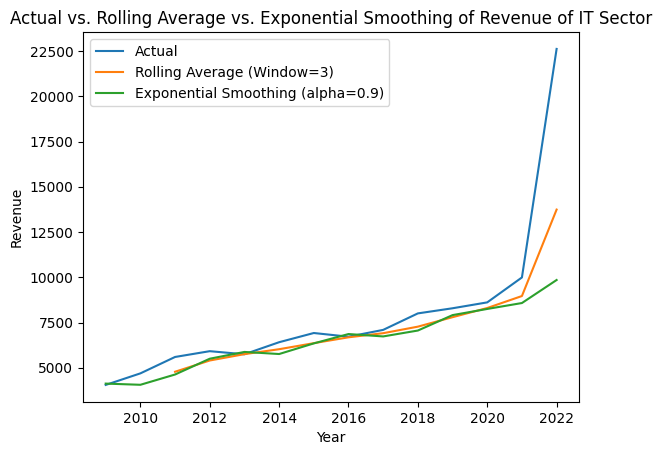

In [98]:
from statsmodels.tsa.api import ExponentialSmoothing


# Plot the actual 'revt' data
plt.plot(it_sector_avg.index, it_sector_avg['revt'], label='Actual')

# Plot the rolling average
plt.plot(it_sector_avg.index, rolling_avg_revt, label='Rolling Average (Window=3)')

# Plot the exponential smoothing results
plt.plot(it_sector_avg.index, predictions_revt, label='Exponential Smoothing (alpha=0.9)')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.title('Actual vs. Rolling Average vs. Exponential Smoothing of Revenue of IT Sector')
plt.legend()

# Show the plot
plt.show()


The graph suggests both exponential smoothing and moving average provide decent forecasts for our IT sector data. However, with only 13 data points, we should be cautious about drawing definitive conclusions. The high alpha value in exponential smoothing allows it to adapt to changes quickly, but this might be overly sensitive to random fluctuations in such a small dataset. While the moving average performs well due to the seemingly stable data, its limited window size might miss subtler trends or sudden shifts. To determine the optimal forecasting method for the IT sector with more confidence, additional data would be highly beneficial.

In [99]:
rolling_avg_roa = it_sector_avg['roa'].rolling(window=3).mean()

# Print the first few rows of the rolling average
print(rolling_avg_roa)


year
2009.0         NaN
2010.0         NaN
2011.0    0.123100
2012.0    0.139258
2013.0    0.130565
2014.0    0.124717
2015.0    0.125831
2016.0    0.128158
2017.0    0.130988
2018.0    0.131179
2019.0    0.126801
2020.0    0.124381
2021.0    0.128056
2022.0    0.146477
Name: roa, dtype: float64


In [100]:
from statsmodels.tsa.api import ExponentialSmoothing

# Perform exponential smoothing
model_roa = ExponentialSmoothing(it_sector_avg['roa'], initialization_method='estimated')
fit_model_roa = model_roa.fit(smoothing_level = 0.9)

# Get predictions
predictions_roa = fit_model_roa.predict(start=it_sector_avg.index[0], end=it_sector_avg.index[-1])

# Print the predictions
print(predictions_roa)


year
2009.0    0.083997
2010.0    0.077651
2011.0    0.140991
2012.0    0.143992
2013.0    0.127277
2014.0    0.122484
2015.0    0.126352
2016.0    0.128519
2017.0    0.128890
2018.0    0.134634
2019.0    0.129864
2020.0    0.117205
2021.0    0.126931
2022.0    0.139015
dtype: float64


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


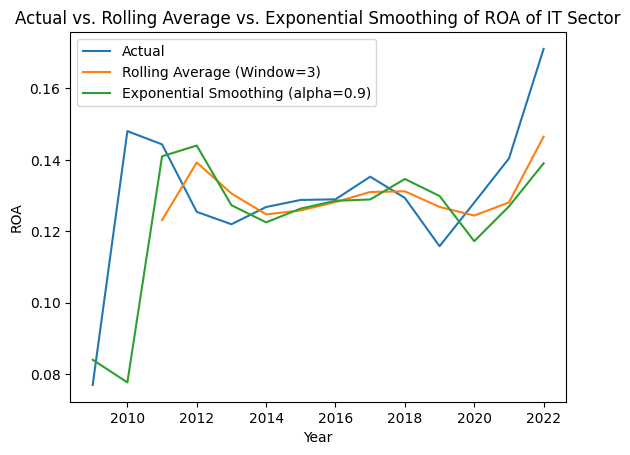

In [101]:
from statsmodels.tsa.api import ExponentialSmoothing

# Plot the actual 'revt' data
plt.plot(it_sector_avg.index, it_sector_avg['roa'], label='Actual')

# Plot the rolling average
plt.plot(it_sector_avg.index, rolling_avg_roa, label='Rolling Average (Window=3)')

# Plot the exponential smoothing results
plt.plot(it_sector_avg.index, predictions_roa, label='Exponential Smoothing (alpha=0.9)')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('ROA')
plt.title('Actual vs. Rolling Average vs. Exponential Smoothing of ROA of IT Sector')
plt.legend()

# Show the plot
plt.show()


The graph highlights the challenges of forecasting with volatile data. The moving average struggles to keep up with the sharp increases and decreases, resulting in less accurate forecasts. Exponential smoothing, however, demonstrates better performance due to its ability to react quickly to changes. A high alpha value likely contributes to this by giving more weight to recent data points, allowing the model to adapt to the fluctuations in the data.

---
## Key Takeaways

1. **Feature Engineering:** A review of the data identified features with high multicollinearity, necessitating the removal of redundant predictors such as specific employment titles and financial metrics like capital expenditures and property, plant, and equipment.
2. **Board Composition and Financial Performance**: A statistically significant positive correlation was observed between the presence of CEOs and chairmen on company boards and both revenue and net income. Conversely, an increase in the number of presidents on the board was associated with a decrease in these financial performance metrics.
3. **Impact of Board Diversity**: The analysis revealed a positive association between increased female representation on boards and both revenue and net income. Additionally, the presence of individuals from certain ethnic backgrounds, such as Black or African American, Hispanic or Latin American, and Indian or South Asian, exhibited a positive correlation with company financial performance.
4. **Board Experience and Performance**: Companies with boards comprised of members with higher average ages, potentially indicating greater experience and tenure, demonstrated a tendency towards higher revenue and net income.
5. **Sectoral Variations**: The relationship between board composition and financial performance was found to be contingent upon the specific industry sector. For instance, in the technology sector, an increased number of CEOs or chairmen on the board positively impacted revenue, while the healthcare sector exhibited a more pronounced positive effect on revenue with a higher CEO presence.
6. **Forecasting with Considerations**: Exponential smoothing and moving average techniques were employed to forecast revenue trends within the IT sector. While both methods yielded relatively reasonable forecasts, caution was advised due to the limitations imposed by the comparatively small dataset size.
7. **Exploratory Data Analysis (EDA)**: The application of exploratory data analysis techniques provided valuable insights into the distribution of board member demographics, the prevalence of various employment titles, and trends in female representation over time. Furthermore, the analysis revealed significant differences in board composition and financial performance across various industry sectors.
8. **Sector-Specific Analysis**: The analysis identified sector-specific trends in revenue, average board member age, and the number of outside public board members. These findings offer valuable insights into industry dynamics and illuminate potential areas for further investigation or strategic focus within specific sectors.
---

## Dashboard

In [102]:
from IPython.display import HTML

# Replace the URL below with the URL of your Looker dashboard
looker_dashboard_url = "https://lookerstudio.google.com/embed/u/0/reporting/ab9889bf-0d31-4f88-86f6-cd153a90fbf5/page/p_gxuyj1uwgd"

# HTML code for embedding the dashboard
dashboard_html = f"""
<iframe width="1000" height="1700" src="{looker_dashboard_url}" frameborder="0" allowfullscreen></iframe>
"""

# Display the HTML code in the Colab notebook
HTML(dashboard_html)